# Generating the ideal distribution
This notebook was written by Yubo Wang. It contains jupyter notebook code for generating the ideal distribution in the XC Running.
## General Question:
According to the previous research, the win rate of a school in the XC Running should be the rato between its popupation and the total population within the division. Then as we want to investigate the top 16 schools in each competition, we need to generate a new distribution based on the origional distributio of win rate.
## Our Approach:
We use a randomized process to sample from the origional distribution of win rate. Then we simulate the school who get the first place, then we remove that school from the total school list and total population and repeat this process for getting all the 16 schools. Then we repeat the process of generating 16 schools many time to get the frequency of getting into the top 16 for each school and calculate the probability for each of them.

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
from scipy import stats

### DataFrames:
#### school information (501$\times$4)
df_all
* ID (int): unique school ID number
* Name (str): school name
* pop (int): number of girl students in school
* div (str): I, II, or III depending on size

In [2]:
df_all = pd.read_csv(r"allxc.csv")
df_all = df_all[df_all["div"] == "I"]
df_all = df_all.sort_values("pop").reset_index().loc[:, "ID":"pop"]

In [3]:
def run_once():
    """
    this function use a randomized process to generate top 16 schools based on population
    return: an numpy array (int) of ID 16 schools
    """
    temp = np.empty(shape=16, dtype=np.int16)
    current_all = df_all.copy()
    current_total_pop = current_all["pop"].sum()
    count = 0

    for i in range(16):
        rand_num = random.random()
        cumulative_prob = 0
        for index in current_all.index:
            current_prob = cumulative_prob + current_all.loc[index, "pop"] / current_total_pop
            if cumulative_prob <= rand_num < current_prob:
                temp[count] = index
                count += 1
                current_total_pop -= current_all.loc[index, "pop"]
                current_all = current_all.drop(index)
                break
            cumulative_prob = current_prob

    return temp

In [4]:
def simulation(repeat):
    """
    this function repeat the process of generating top 16 schools many times
    params: repeat: number of repeat
    return: an numpy array (float) of probability of being into the top 16 for each school
    """
    temp = np.zeros(shape=167, dtype=np.float64)
    for i in range(repeat):
        result = run_once()
        for j in result:
            temp[j] += 1.0
    return temp / repeat

In [5]:
def repeat_simulation(repeat, simulation_repeat):
    """
    this function repeat the simulation many times, this function will be helpful when we use multiprocess. The total time of simulation will be repeat * simulation_repeat.
    params:
        repeat: number of repeat of simulation
        simulation_repeat: number of repeat in each simulation
    return: an numpy array (float) of probability of being into the top 16 for each school
    """
    result = np.empty(shape=(167, repeat), dtype=np.float64)
    for i in range(repeat):
        # print(i)
        temp = simulation(simulation_repeat)
        for index, val in enumerate(temp):
            result[index][i] = val
    return result

In [6]:
result = repeat_simulation(50,5000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [7]:
# low = []
# high = []
mean_val = [i.mean() for i in result]

# we can calculate the confidence interval based on all the number of simulation
# for i in range(167):
#     mean, sigma = np.mean(result[i]), np.std(result[i])
#     intv = stats.norm.interval(0.95, loc=mean, scale=sigma)
#     low.append(intv[0])
#     high.append(intv[1])

# final_result = pd.DataFrame({"mean": mean_val, "high": high, "low": low})
final_result = pd.DataFrame({"mean": mean_val, "ID": df_all["ID"], "pop": df_all["pop"]})
# final_result["ID"] = df_all["ID"]
# final_result["pop"] = df_all["pop"]
final_result.set_index("ID", inplace=True)
final_result.to_csv("ideal_distribution.csv")

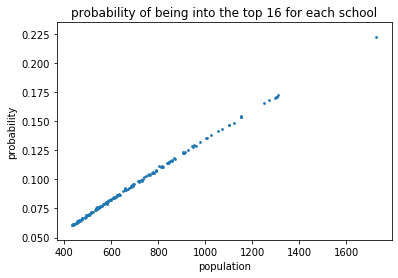

In [2]:
plt.scatter(list(pd.read_csv("ideal_distribution.csv")["pop"]), list(pd.read_csv("ideal_distribution.csv")["mean"]), label="mean", s=3)
plt.xlabel("population")
plt.ylabel("probability")
plt.title("probability of being into the top 16 for each school")
plt.savefig('prob_vs_pop', transparent=True)
plt.show()